In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Set a seed for reproducibility
seed_value = 42
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)

## Data Loading

In [3]:
df_bank_a = pd.read_csv('../data/BankA_preprocessed.csv')
df_bank_b = pd.read_csv('../data/BankB_preprocessed.csv')
df_bank_c = pd.read_csv('../data/BankC_preprocessed.csv')

In [4]:
df_all = pd.concat([df_bank_a, df_bank_b, df_bank_c])

In [5]:
# randomly selected fraction of the data
df_all = df_all.sample(frac=0.05, random_state=seed_value)
df_bank_a = df_bank_a.sample(frac=0.05, random_state=seed_value)
df_bank_b = df_bank_b.sample(frac=0.05, random_state=seed_value)
df_bank_c = df_bank_c.sample(frac=0.05, random_state=seed_value)

## Data Preprocessing

### Create bins for age

In [6]:
# Convert age in bins of 10 years
df_all['age'] = pd.cut(df_all['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90'])
df_bank_a['age'] = pd.cut(df_bank_a['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90'])
df_bank_b['age'] = pd.cut(df_bank_b['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90'])
df_bank_c['age'] = pd.cut(df_bank_c['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90'])

### Target Column

In [7]:
# One-hot encode the categorical columns
categorical_columns = df_all.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['age']))
df_all = pd.get_dummies(df_all, columns=categorical_columns)

# One-hot encode the categorical columns
categorical_columns = df_bank_a.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['age']))
df_bank_a = pd.get_dummies(df_bank_a, columns=categorical_columns)

# One-hot encode the categorical columns
categorical_columns = df_bank_b.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['age']))
df_bank_b = pd.get_dummies(df_bank_b, columns=categorical_columns)

# One-hot encode the categorical columns
categorical_columns = df_bank_c.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['age']))
df_bank_c = pd.get_dummies(df_bank_c, columns=categorical_columns)

## Model Training

### Data Splitting for Training and Testing

In [8]:
# number of rows in each dataset
print(f"Number of rows in df_all:    {len(df_all)}")
print(f"Number of rows in df_bank_a: {len(df_bank_a)}")
print(f"Number of rows in df_bank_b: {len(df_bank_b)}")
print(f"Number of rows in df_bank_c: {len(df_bank_c)}")

Number of rows in df_all:    40000
Number of rows in df_bank_a: 11308
Number of rows in df_bank_b: 20162
Number of rows in df_bank_c: 8530


In [9]:
# Create a test set that contains 20% of the data from each bank
df_bank_a_test = df_bank_a.sample(frac=0.2, random_state=seed_value)
df_bank_b_test = df_bank_b.sample(frac=0.2, random_state=seed_value)
df_bank_c_test = df_bank_c.sample(frac=0.2, random_state=seed_value)

# Create a training set that contains the remaining 80% of the data from each bank
df_bank_a_train = df_bank_a.drop(df_bank_a_test.index)
df_bank_b_train = df_bank_b.drop(df_bank_b_test.index)
df_bank_c_train = df_bank_c.drop(df_bank_c_test.index)

# Combine the training sets into one training set
df_train = pd.concat([df_bank_a_train, df_bank_b_train, df_bank_c_train])

# Combine the test sets into one test set
df_test = pd.concat([df_bank_a_test, df_bank_b_test, df_bank_c_test])

In [10]:
# Split the training and test sets into X and y
X_train = df_train.drop('income', axis=1)
y_train = df_train['income']
X_test = df_test.drop('income', axis=1)
y_test = df_test['income']

X_train_bank_a = df_bank_a_train.drop('income', axis=1)
y_train_bank_a = df_bank_a_train['income']
X_test_bank_a = df_bank_a_test.drop('income', axis=1)
y_test_bank_a = df_bank_a_test['income']

X_train_bank_b = df_bank_b_train.drop('income', axis=1)
y_train_bank_b = df_bank_b_train['income']
X_test_bank_b = df_bank_b_test.drop('income', axis=1)
y_test_bank_b = df_bank_b_test['income']

X_train_bank_c = df_bank_c_train.drop('income', axis=1)
y_train_bank_c = df_bank_c_train['income']
X_test_bank_c = df_bank_c_test.drop('income', axis=1)
y_test_bank_c = df_bank_c_test['income']

In [11]:
X_train.sample(5)


,hours-per-week,capital-diff,workclass_Federal-gov,workclass_Local-gov,workclass_Not-working,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_unknown,...,native-country_Unknown,age_0-20,age_20-30,age_30-40,age_40-50,age_50-60,age_60-70,age_70-80,age_80-90,age_>90
37125,45,0,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
362138,25,0,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
36114,40,0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
115176,40,0,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
85277,50,0,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


### Model Training

#### Finding good hyperparameters for different models

In [12]:
# Find the best hyperparameters for a decision tree classifier

# Create a decision tree classifier
clf_dt = DecisionTreeClassifier(random_state=seed_value)

# Define the grid search parameters
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16],
    'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16],
    'max_features': [2, 4, 6, 8, 10, 12, 14, 16]
}

grid_search_dt = RandomizedSearchCV(estimator=clf_dt, n_iter=15, param_distributions=param_grid_dt, cv=5, n_jobs=-1, verbose=0)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_dt.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)
print(grid_search_dt.best_estimator_)

{'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 14, 'max_depth': 16, 'criterion': 'gini'}
0.8413437500000001
DecisionTreeClassifier(max_depth=16, max_features=14, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)


In [13]:
# Find the best hyperparameters for a logistic regression classifier

# Create a logistic regression classifier
clf_lr = LogisticRegression(random_state=seed_value)

# Define the grid search parameters
param_grid_lg = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000, 2000],
}

grid_search_lg = RandomizedSearchCV(estimator=clf_lr, n_iter=15, param_distributions=param_grid_lg, cv=5, n_jobs=-1, verbose=0)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_lg.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_lg.best_params_)
print(grid_search_lg.best_score_)
print(grid_search_lg.best_estimator_)

{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 2000, 'C': 0.1}
0.83278125
LogisticRegression(C=0.1, max_iter=2000, random_state=42, solver='liblinear')


In [14]:
# Find the best hyperparameters for a random forest classifier

# Create a random forest classifier
clf_rf = RandomForestClassifier(random_state=seed_value)

# Define the grid search parameters
param_grid_rf = {
    'n_estimators': [3, 5, 7, 9],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 10, 12, 14, 16, 32],
    'min_samples_split': [10, 32, 128, 256, 512, 1024],
    'min_samples_leaf': [16, 32, 64, 128, 256],
    'max_features': [2, 4, 6, 8, 10, 12, 14, 16]
}

grid_search_rf = RandomizedSearchCV(estimator=clf_rf, n_iter=15, param_distributions=param_grid_rf, cv=5, n_jobs=-1, verbose=0)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_rf.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)
print(grid_search_rf.best_estimator_)

{'n_estimators': 7, 'min_samples_split': 256, 'min_samples_leaf': 64, 'max_features': 10, 'max_depth': 14, 'criterion': 'gini'}
0.8394999999999999
RandomForestClassifier(max_depth=14, max_features=10, min_samples_leaf=64,
                       min_samples_split=256, n_estimators=7, random_state=42)


In [15]:
# Find the best hyperparameters for a gradient boosting classifier

# Create a gradient boosting classifier
clf_gb = GradientBoostingClassifier(random_state=seed_value)

# Define the grid search parameters
param_grid_gb = {
    'n_estimators': [3, 9, 50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_depth': [2, 4, 6, 8, 10, 12, 36],
    'min_samples_split': [10, 12, 14, 16, 32, 128],
    'min_samples_leaf': [16, 32, 64, 128, 256],
    'max_features': [2, 4, 6, 8, 16, 20, 32]
}

grid_search_gb = RandomizedSearchCV(estimator=clf_gb, n_iter=15, param_distributions=param_grid_gb, cv=5, n_jobs=-1, verbose=0)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_gb.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_gb.best_params_)
print(grid_search_gb.best_score_)
print(grid_search_gb.best_estimator_)

{'n_estimators': 100, 'min_samples_split': 14, 'min_samples_leaf': 32, 'max_features': 6, 'max_depth': 8, 'learning_rate': 0.1}
0.84903125
GradientBoostingClassifier(max_depth=8, max_features=6, min_samples_leaf=32,
                           min_samples_split=14, random_state=42)


In [16]:
# find the best hyperparameters for a MLP classifier

# Create an MLP classifier
clf_mlp = MLPClassifier(random_state=seed_value)

# Define the grid search parameters for MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 30), (50,), (100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 300],
    'learning_rate_init': [0.001, 0.01],
    'batch_size': [64, 128]
}

# Setup RandomizedSearchCV for MLP
grid_search_mlp = RandomizedSearchCV(estimator=clf_mlp, param_distributions=param_grid_mlp, n_iter=15, cv=5, n_jobs=-1, verbose=1, random_state=seed_value)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_mlp.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_mlp.best_params_)
print(grid_search_mlp.best_score_)
print(grid_search_mlp.best_estimator_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'batch_size': 128, 'alpha': 0.01, 'activation': 'relu'}
0.8348125
MLPClassifier(alpha=0.01, batch_size=128, learning_rate='adaptive',
              max_iter=300, random_state=42)


#### Train a model with all data from all banks

In [18]:
# Define and Train the models with the best hyperparameters
model_global_dt = clone(grid_search_dt.best_estimator_).fit(X_train, y_train)
model_global_lg = clone(grid_search_lg.best_estimator_).fit(X_train, y_train)
model_global_rf = clone(grid_search_rf.best_estimator_).fit(X_train, y_train)
model_global_gb = clone(grid_search_gb.best_estimator_).fit(X_train, y_train)
model_global_mlp = clone(grid_search_mlp.best_estimator_).fit(X_train, y_train)

model_bank_a_dt = clone(grid_search_dt.best_estimator_).fit(X_train_bank_a, y_train_bank_a)
model_bank_a_lg = clone(grid_search_lg.best_estimator_).fit(X_train_bank_a, y_train_bank_a)
model_bank_a_rf = clone(grid_search_rf.best_estimator_).fit(X_train_bank_a, y_train_bank_a)
model_bank_a_gb = clone(grid_search_gb.best_estimator_).fit(X_train_bank_a, y_train_bank_a)
model_bank_a_mlp = clone(grid_search_mlp.best_estimator_).fit(X_train_bank_a, y_train_bank_a)

model_bank_b_dt = clone(grid_search_dt.best_estimator_).fit(X_train_bank_b, y_train_bank_b)
model_bank_b_lg = clone(grid_search_lg.best_estimator_).fit(X_train_bank_b, y_train_bank_b)
model_bank_b_rf = clone(grid_search_rf.best_estimator_).fit(X_train_bank_b, y_train_bank_b)
model_bank_b_gb = clone(grid_search_gb.best_estimator_).fit(X_train_bank_b, y_train_bank_b)
model_bank_b_mlp = clone(grid_search_mlp.best_estimator_).fit(X_train_bank_b, y_train_bank_b)

model_bank_c_dt = clone(grid_search_dt.best_estimator_).fit(X_train_bank_c, y_train_bank_c)
model_bank_c_lg = clone(grid_search_lg.best_estimator_).fit(X_train_bank_c, y_train_bank_c)
model_bank_c_rf = clone(grid_search_rf.best_estimator_).fit(X_train_bank_c, y_train_bank_c)
model_bank_c_gb = clone(grid_search_gb.best_estimator_).fit(X_train_bank_c, y_train_bank_c)
model_bank_c_mlp = clone(grid_search_mlp.best_estimator_).fit(X_train_bank_c, y_train_bank_c)

In [20]:
# Export the trained models
joblib.dump(model_global_dt, './models/model_global_dt.pkl')
joblib.dump(model_global_lg, './models/model_global_lg.pkl')
joblib.dump(model_global_rf, './models/model_global_rf.pkl')
joblib.dump(model_global_gb, './models/model_global_gb.pkl')
joblib.dump(model_global_mlp, './models/model_global_mlp.pkl')

joblib.dump(model_bank_a_dt, './models/model_bank_a_dt.pkl')
joblib.dump(model_bank_a_lg, './models/model_bank_a_lg.pkl')
joblib.dump(model_bank_a_rf, './models/model_bank_a_rf.pkl')
joblib.dump(model_bank_a_gb, './models/model_bank_a_gb.pkl')
joblib.dump(model_bank_a_mlp, './models/model_bank_a_mlp.pkl')

joblib.dump(model_bank_b_dt, './models/model_bank_b_dt.pkl')
joblib.dump(model_bank_b_lg, './models/model_bank_b_lg.pkl')
joblib.dump(model_bank_b_rf, './models/model_bank_b_rf.pkl')
joblib.dump(model_bank_b_gb, './models/model_bank_b_gb.pkl')
joblib.dump(model_bank_b_mlp, './models/model_bank_b_mlp.pkl')

joblib.dump(model_bank_c_dt, './models/model_bank_c_dt.pkl')
joblib.dump(model_bank_c_lg, './models/model_bank_c_lg.pkl')
joblib.dump(model_bank_c_rf, './models/model_bank_c_rf.pkl')
joblib.dump(model_bank_c_gb, './models/model_bank_c_gb.pkl')
joblib.dump(model_bank_c_mlp, './models/model_bank_c_mlp.pkl')

['./models/model_bank_c_mlp.pkl']

#### Evaluate all the models

In [21]:
# Evaluate the global models on the global test set

## Predict
y_pred_global_global_dt = model_global_dt.predict(X_test)
y_pred_global_global_lg = model_global_lg.predict(X_test)
y_pred_global_global_rf = model_global_rf.predict(X_test)
y_pred_global_global_gb = model_global_gb.predict(X_test)
y_pred_global_global_mlp = model_global_mlp.predict(X_test)
## Metrics
acc_global_global_dt = accuracy_score(y_test, y_pred_global_global_dt)
acc_global_global_lg = accuracy_score(y_test, y_pred_global_global_lg)
acc_global_global_rf = accuracy_score(y_test, y_pred_global_global_rf)
acc_global_global_gb = accuracy_score(y_test, y_pred_global_global_gb)
acc_global_global_mlp = accuracy_score(y_test, y_pred_global_global_mlp)
f1_global_global_dt = f1_score(y_test, y_pred_global_global_dt)
f1_global_global_lg = f1_score(y_test, y_pred_global_global_lg)
f1_global_global_rf = f1_score(y_test, y_pred_global_global_rf)
f1_global_global_gb = f1_score(y_test, y_pred_global_global_gb)
f1_global_global_mlp = f1_score(y_test, y_pred_global_global_mlp)
kappa_global_global_dt = cohen_kappa_score(y_test, y_pred_global_global_dt)
kappa_global_global_lg = cohen_kappa_score(y_test, y_pred_global_global_lg)
kappa_global_global_rf = cohen_kappa_score(y_test, y_pred_global_global_rf)
kappa_global_global_gb = cohen_kappa_score(y_test, y_pred_global_global_gb)
kappa_global_global_mlp = cohen_kappa_score(y_test, y_pred_global_global_mlp)


# Evaluate the global models on the bank A, B and C test sets
## Predict
y_pred_global_bank_a_dt = model_global_dt.predict(X_test_bank_a)
y_pred_global_bank_a_lg = model_global_lg.predict(X_test_bank_a)
y_pred_global_bank_a_rf = model_global_rf.predict(X_test_bank_a)
y_pred_global_bank_a_gb = model_global_gb.predict(X_test_bank_a)
y_pred_global_bank_a_mlp = model_global_mlp.predict(X_test_bank_a)

y_pred_global_bank_b_dt = model_global_dt.predict(X_test_bank_b)
y_pred_global_bank_b_lg = model_global_lg.predict(X_test_bank_b)
y_pred_global_bank_b_rf = model_global_rf.predict(X_test_bank_b)
y_pred_global_bank_b_gb = model_global_gb.predict(X_test_bank_b)
y_pred_global_bank_b_mlp = model_global_mlp.predict(X_test_bank_b)

y_pred_global_bank_c_dt = model_global_dt.predict(X_test_bank_c)
y_pred_global_bank_c_lg = model_global_lg.predict(X_test_bank_c)
y_pred_global_bank_c_rf = model_global_rf.predict(X_test_bank_c)
y_pred_global_bank_c_gb = model_global_gb.predict(X_test_bank_c)
y_pred_global_bank_c_mlp = model_global_mlp.predict(X_test_bank_c)
## Metrics
acc_global_bank_a_dt = accuracy_score(y_test_bank_a, y_pred_global_bank_a_dt)
acc_global_bank_a_lg = accuracy_score(y_test_bank_a, y_pred_global_bank_a_lg)
acc_global_bank_a_rf = accuracy_score(y_test_bank_a, y_pred_global_bank_a_rf)
acc_global_bank_a_gb = accuracy_score(y_test_bank_a, y_pred_global_bank_a_gb)
acc_global_bank_a_mlp = accuracy_score(y_test_bank_a, y_pred_global_bank_a_mlp)
f1_global_bank_a_dt = f1_score(y_test_bank_a, y_pred_global_bank_a_dt)
f1_global_bank_a_lg = f1_score(y_test_bank_a, y_pred_global_bank_a_lg)
f1_global_bank_a_rf = f1_score(y_test_bank_a, y_pred_global_bank_a_rf)
f1_global_bank_a_gb = f1_score(y_test_bank_a, y_pred_global_bank_a_gb)
f1_global_bank_a_mlp = f1_score(y_test_bank_a, y_pred_global_bank_a_mlp)
kappa_global_bank_a_dt = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_dt)
kappa_global_bank_a_lg = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_lg)
kappa_global_bank_a_rf = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_rf)
kappa_global_bank_a_gb = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_gb)
kappa_global_bank_a_mlp = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_mlp)

acc_global_bank_b_dt = accuracy_score(y_test_bank_b, y_pred_global_bank_b_dt)
acc_global_bank_b_lg = accuracy_score(y_test_bank_b, y_pred_global_bank_b_lg)
acc_global_bank_b_rf = accuracy_score(y_test_bank_b, y_pred_global_bank_b_rf)
acc_global_bank_b_gb = accuracy_score(y_test_bank_b, y_pred_global_bank_b_gb)
acc_global_bank_b_mlp = accuracy_score(y_test_bank_b, y_pred_global_bank_b_mlp)
f1_global_bank_b_dt = f1_score(y_test_bank_b, y_pred_global_bank_b_dt)
f1_global_bank_b_lg = f1_score(y_test_bank_b, y_pred_global_bank_b_lg)
f1_global_bank_b_rf = f1_score(y_test_bank_b, y_pred_global_bank_b_rf)
f1_global_bank_b_gb = f1_score(y_test_bank_b, y_pred_global_bank_b_gb)
f1_global_bank_b_mlp = f1_score(y_test_bank_b, y_pred_global_bank_b_mlp)
kappa_global_bank_b_dt = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_dt)
kappa_global_bank_b_lg = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_lg)
kappa_global_bank_b_rf = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_rf)
kappa_global_bank_b_gb = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_gb)
kappa_global_bank_b_mlp = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_mlp)

acc_global_bank_c_dt = accuracy_score(y_test_bank_c, y_pred_global_bank_c_dt)
acc_global_bank_c_lg = accuracy_score(y_test_bank_c, y_pred_global_bank_c_lg)
acc_global_bank_c_rf = accuracy_score(y_test_bank_c, y_pred_global_bank_c_rf)
acc_global_bank_c_gb = accuracy_score(y_test_bank_c, y_pred_global_bank_c_gb)
acc_global_bank_c_mlp = accuracy_score(y_test_bank_c, y_pred_global_bank_c_mlp)
f1_global_bank_c_dt = f1_score(y_test_bank_c, y_pred_global_bank_c_dt)
f1_global_bank_c_lg = f1_score(y_test_bank_c, y_pred_global_bank_c_lg)
f1_global_bank_c_rf = f1_score(y_test_bank_c, y_pred_global_bank_c_rf)
f1_global_bank_c_gb = f1_score(y_test_bank_c, y_pred_global_bank_c_gb)
f1_global_bank_c_mlp = f1_score(y_test_bank_c, y_pred_global_bank_c_mlp)
kappa_global_bank_c_dt = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_dt)
kappa_global_bank_c_lg = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_lg)
kappa_global_bank_c_rf = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_rf)
kappa_global_bank_c_gb = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_gb)
kappa_global_bank_c_mlp = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_mlp)


# Evaluate the bank A models on the bank A test set
## Predict
y_pred_bank_a_bank_a_dt = model_bank_a_dt.predict(X_test_bank_a)
y_pred_bank_a_bank_a_lg = model_bank_a_lg.predict(X_test_bank_a)
y_pred_bank_a_bank_a_rf = model_bank_a_rf.predict(X_test_bank_a)
y_pred_bank_a_bank_a_gb = model_bank_a_gb.predict(X_test_bank_a)
y_pred_bank_a_bank_a_mlp = model_bank_a_mlp.predict(X_test_bank_a)
## Metrics
acc_bank_a_bank_a_dt = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_dt)
acc_bank_a_bank_a_lg = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_lg)
acc_bank_a_bank_a_rf = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_rf)
acc_bank_a_bank_a_gb = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_gb)
acc_bank_a_bank_a_mlp = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_mlp)
f1_bank_a_bank_a_dt = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_dt)
f1_bank_a_bank_a_lg = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_lg)
f1_bank_a_bank_a_rf = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_rf)
f1_bank_a_bank_a_gb = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_gb)
f1_bank_a_bank_a_mlp = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_mlp)
kappa_bank_a_bank_a_dt = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_dt)
kappa_bank_a_bank_a_lg = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_lg)
kappa_bank_a_bank_a_rf = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_rf)
kappa_bank_a_bank_a_gb = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_gb)
kappa_bank_a_bank_a_mlp = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_mlp)


# Evaluate the bank B models on the bank B test set
## Predict
y_pred_bank_b_bank_b_dt = model_bank_b_dt.predict(X_test_bank_b)
y_pred_bank_b_bank_b_lg = model_bank_b_lg.predict(X_test_bank_b)
y_pred_bank_b_bank_b_rf = model_bank_b_rf.predict(X_test_bank_b)
y_pred_bank_b_bank_b_gb = model_bank_b_gb.predict(X_test_bank_b)
y_pred_bank_b_bank_b_mlp = model_bank_b_mlp.predict(X_test_bank_b)
## Metrics
acc_bank_b_bank_b_dt = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_dt)
acc_bank_b_bank_b_lg = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_lg)
acc_bank_b_bank_b_rf = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_rf)
acc_bank_b_bank_b_gb = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_gb)
acc_bank_b_bank_b_mlp = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_mlp)
f1_bank_b_bank_b_dt = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_dt)
f1_bank_b_bank_b_lg = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_lg)
f1_bank_b_bank_b_rf = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_rf)
f1_bank_b_bank_b_gb = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_gb)
f1_bank_b_bank_b_mlp = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_mlp)
kappa_bank_b_bank_b_dt = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_dt)
kappa_bank_b_bank_b_lg = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_lg)
kappa_bank_b_bank_b_rf = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_rf)
kappa_bank_b_bank_b_gb = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_gb)
kappa_bank_b_bank_b_mlp = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_mlp)


# Evaluate the bank C models on the bank C test set
## Predict
y_pred_bank_c_bank_c_dt = model_bank_c_dt.predict(X_test_bank_c)
y_pred_bank_c_bank_c_lg = model_bank_c_lg.predict(X_test_bank_c)
y_pred_bank_c_bank_c_rf = model_bank_c_rf.predict(X_test_bank_c)
y_pred_bank_c_bank_c_gb = model_bank_c_gb.predict(X_test_bank_c)
y_pred_bank_c_bank_c_mlp = model_bank_c_mlp.predict(X_test_bank_c)
## Metrics
acc_bank_c_bank_c_dt = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_dt)
acc_bank_c_bank_c_lg = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_lg)
acc_bank_c_bank_c_rf = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_rf)
acc_bank_c_bank_c_gb = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_gb)
acc_bank_c_bank_c_mlp = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_mlp)
f1_bank_c_bank_c_dt = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_dt)
f1_bank_c_bank_c_lg = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_lg)
f1_bank_c_bank_c_rf = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_rf)
f1_bank_c_bank_c_gb = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_gb)
f1_bank_c_bank_c_mlp = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_mlp)
kappa_bank_c_bank_c_dt = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_dt)
kappa_bank_c_bank_c_lg = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_lg)
kappa_bank_c_bank_c_rf = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_rf)
kappa_bank_c_bank_c_gb = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_gb)
kappa_bank_c_bank_c_mlp = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_mlp)

In [22]:
# Store all metrics in a dataframe with columns: modeltype, explainability, model, dataset , accuracy, f1, kappa
df_metrics = pd.DataFrame(columns=['modeltype', 'explainability', 'model', 'dataset', 'accuracy', 'f1', 'kappa'])

# Add the global models to the dataframe
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'global model', 'dataset': 'global dataset', 'accuracy': acc_global_global_dt, 'f1': f1_global_global_dt, 'kappa': kappa_global_global_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'global model', 'dataset': 'global dataset', 'accuracy': acc_global_global_lg, 'f1': f1_global_global_lg, 'kappa': kappa_global_global_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'global model', 'dataset': 'global dataset', 'accuracy': acc_global_global_rf, 'f1': f1_global_global_rf, 'kappa': kappa_global_global_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'global model', 'dataset': 'global dataset', 'accuracy': acc_global_global_gb, 'f1': f1_global_global_gb, 'kappa': kappa_global_global_gb}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'MLP', 'explainability': 'low', 'model': 'global model', 'dataset': 'global dataset', 'accuracy': acc_global_global_mlp, 'f1': f1_global_global_mlp, 'kappa': kappa_global_global_mlp}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'global model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_dt, 'f1': f1_global_bank_a_dt, 'kappa': kappa_global_bank_a_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'global model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_lg, 'f1': f1_global_bank_a_lg, 'kappa': kappa_global_bank_a_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_rf, 'f1': f1_global_bank_a_rf, 'kappa': kappa_global_bank_a_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_gb, 'f1': f1_global_bank_a_gb, 'kappa': kappa_global_bank_a_gb}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'MLP', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_mlp, 'f1': f1_global_bank_a_mlp, 'kappa': kappa_global_bank_a_mlp}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'global model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_dt, 'f1': f1_global_bank_b_dt, 'kappa': kappa_global_bank_b_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'global model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_lg, 'f1': f1_global_bank_b_lg, 'kappa': kappa_global_bank_b_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_rf, 'f1': f1_global_bank_b_rf, 'kappa': kappa_global_bank_b_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_gb, 'f1': f1_global_bank_b_gb, 'kappa': kappa_global_bank_b_gb}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'MLP', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_mlp, 'f1': f1_global_bank_b_mlp, 'kappa': kappa_global_bank_b_mlp}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'global model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_dt, 'f1': f1_global_bank_c_dt, 'kappa': kappa_global_bank_c_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'global model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_lg, 'f1': f1_global_bank_c_lg, 'kappa': kappa_global_bank_c_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_rf, 'f1': f1_global_bank_c_rf, 'kappa': kappa_global_bank_c_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_gb, 'f1': f1_global_bank_c_gb, 'kappa': kappa_global_bank_c_gb}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'MLP', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_mlp, 'f1': f1_global_bank_c_mlp, 'kappa': kappa_global_bank_c_mlp}, index=[0])], ignore_index=True)

# Add the bank A models to the dataframe
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'bank A model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_dt, 'f1': f1_bank_a_bank_a_dt, 'kappa': kappa_bank_a_bank_a_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'bank A model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_lg, 'f1': f1_bank_a_bank_a_lg, 'kappa': kappa_bank_a_bank_a_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'bank A model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_rf, 'f1': f1_bank_a_bank_a_rf, 'kappa': kappa_bank_a_bank_a_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'bank A model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_gb, 'f1': f1_bank_a_bank_a_gb, 'kappa': kappa_bank_a_bank_a_gb}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'MLP', 'explainability': 'low', 'model': 'bank A model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_mlp, 'f1': f1_bank_a_bank_a_mlp, 'kappa': kappa_bank_a_bank_a_mlp}, index=[0])], ignore_index=True)

# Add the bank B models to the dataframe
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'bank B model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_dt, 'f1': f1_bank_b_bank_b_dt, 'kappa': kappa_bank_b_bank_b_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'bank B model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_lg, 'f1': f1_bank_b_bank_b_lg, 'kappa': kappa_bank_b_bank_b_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'bank B model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_rf, 'f1': f1_bank_b_bank_b_rf, 'kappa': kappa_bank_b_bank_b_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'bank B model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_gb, 'f1': f1_bank_b_bank_b_gb, 'kappa': kappa_bank_b_bank_b_gb}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'MLP', 'explainability': 'low', 'model': 'bank B model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_mlp, 'f1': f1_bank_b_bank_b_mlp, 'kappa': kappa_bank_b_bank_b_mlp}, index=[0])], ignore_index=True)

# Add the bank C models to the dataframe
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'bank C model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_dt, 'f1': f1_bank_c_bank_c_dt, 'kappa': kappa_bank_c_bank_c_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'bank C model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_lg, 'f1': f1_bank_c_bank_c_lg, 'kappa': kappa_bank_c_bank_c_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'bank C model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_rf, 'f1': f1_bank_c_bank_c_rf, 'kappa': kappa_bank_c_bank_c_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'bank C model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_gb, 'f1': f1_bank_c_bank_c_gb, 'kappa': kappa_bank_c_bank_c_gb}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'MLP', 'explainability': 'low', 'model': 'bank C model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_mlp, 'f1': f1_bank_c_bank_c_mlp, 'kappa': kappa_bank_c_bank_c_mlp}, index=[0])], ignore_index=True)

In [23]:
# Rename dataset to testdataset
df_metrics = df_metrics.rename(columns={'dataset': 'testdataset'})

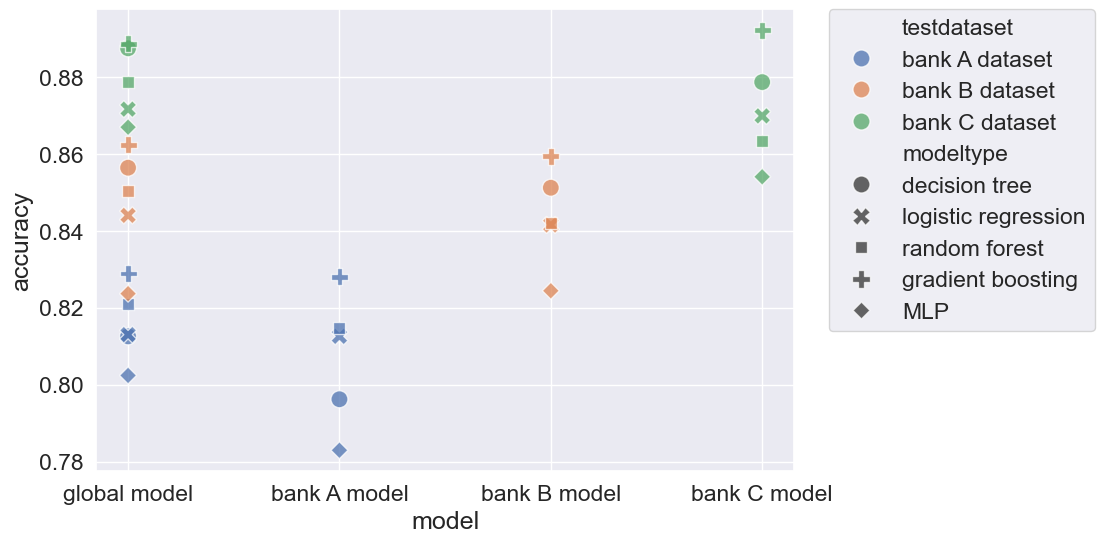

In [24]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(9,6)})
sns.set(font_scale=1.5)
ax = sns.scatterplot(x="model", y="accuracy", hue="testdataset", style="modeltype", data=df_metrics[df_metrics['testdataset'] != 'global dataset'], s=150, alpha=0.75)
ax.set(xlabel='model', ylabel='accuracy')
# Rename the legend titles
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()